## Topic Modelling

We have downloaded some speeches by B. Obama and M. Romney made during US Presidential election 2012. The speeches are uploaded on GitHUB and we would try to find some imortant topics each of their speeches consisted of. We will do Topic modelling using Gensim and visualize these topics using a womderful package called pyLDAvis.

**NOTE:** If pyLDAvis visualization diagrams are NOT visible in this notebook, refer to this jupyter nbviewer version 
https://nbviewer.jupyter.org/github/Rajesh-Nair/Text-modelling-on-speeches/blob/master/Topic%20Modelling%20using%20gensim%20%28LSI%20and%20LDA%29.ipynb


In [1]:
# Find folders and text under a given path
import os

# For dataframe/tables
import pandas as pd

# NLTK package
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Default dictionary
from collections import defaultdict

# Gensim
from gensim import corpora
from gensim import models

# Model evaluation
from gensim.models import CoherenceModel

# Visualization
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

C:\Users\acer\Anaconda3\envs\py35\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Text document folder
folder = 'speeches'

# Stop words set
ignorewords = set(stopwords.words("english"))

# Lemmatizer
lemmatizer = WordNetLemmatizer().lemmatize

#define dictionary  and corpus
dictionary = corpora.Dictionary()
corpus = list()

# Clean text
# 1. Word Tokenize text
# 2. Ignore stopwords and non alpha characters, words less than 4 in length
# 3. conver to lower case
# 4. Lemmatize the words
# 5. Update/Add to Dictionary
# 6. Create Bag of Words
def clean_corpus(text) :
    textlist = list()
    textlist.append([lemmatizer(word.lower()) for word in word_tokenize(text) \
                       if word not in ignorewords and word.isalpha() and len(word) > 4 ])
    dictionary.add_documents(textlist)
    for text in textlist :
        corpus.append(dictionary.doc2bow(text, allow_update=True))    
    return(textlist)



In [3]:
# Read, clean and convert the speeches in to Tf-idf
corpus_tfidf = dict()
textlist = defaultdict(list)
for fld in  os.listdir(folder) :
    corpus = [] # Re-Initialize    
    for file in os.listdir(folder + '\\' + fld) :
        txtfile = folder + '\\' + fld + '\\' + file
        with open(txtfile, 'r',errors='ignore') as fobj :        
            textlist[fld].append(clean_corpus(fobj.read()))
    # Tf-idf model
    Tfidf = models.TfidfModel(corpus, smartirs='ntc')
    corpus_tfidf[fld] = Tfidf[corpus]    

# Store the dictionary
corpus_dict = dictionary

In [4]:
# LSI model
lsi = dict()
num_topics = 15 
num_words = 15

for fld in corpus_tfidf.keys() :
    lsi[fld] = models.LsiModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics)


In [102]:
# Display the topics and words associated
for fld in corpus_tfidf.keys() :    
    print('*'*80)
    print(fld.upper())
    print(pd.DataFrame({"Topic "+ str(i+101)[1:]:[topic[0] for topic in lsi[fld].show_topic(i,num_words)] \
                                    for i in range(num_topics)}, index = [i+1 for i in range(num_words)] ))

********************************************************************************
ROMNEY
   Topic 01    Topic 02      Topic 03    Topic 04      Topic 05    Topic 06  \
1   liberal       found         reply       peace      applause    applause   
2     found   searching        cancel      regime       dreamer    audience   
3    crisis   requested         leave        ally         plant    remember   
4   program     perhaps         berta     dreamer        saving     liberal   
5    school     nothing        falcon      saving      remember      regime   
6    budget       could       library      weapon        little     teacher   
7     going     liberal        valley    applause  unidentified       peace   
8    little       going      provided     veteran      audience      weapon   
9    dollar      crisis         tweet       plant         going        ally   
10   nation      budget          view     iranian     attacking     iranian   
11  percent       reply  presidential      

In [116]:
# LDA model - evaluation
num_of_passes = 10
x = defaultdict(list); y = defaultdict(list); z = defaultdict(list)
for fld in corpus_tfidf.keys() :
    for num_topics in range(5,16,1) :
        lda_model = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics, passes = num_of_passes,\
                                  chunksize=100, random_state=123, update_every=1)
        coherence_model_lda = CoherenceModel(model=lda_model,texts = np.squeeze(textlist[fld]), dictionary=corpus_dict, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        x[fld].append(num_topics) ; y[fld].append(coherence_score)
        print("{}'s speech : Number of topics is {}, coherence score is {}".format(fld,num_topics,coherence_score))


romney's speech : Number of topics is 5, coherence score is 0.41945853242207026
romney's speech : Number of topics is 6, coherence score is 0.4871722014730797
romney's speech : Number of topics is 7, coherence score is 0.46803769315975086
romney's speech : Number of topics is 8, coherence score is 0.4769630959594821
romney's speech : Number of topics is 9, coherence score is 0.52603829525948
romney's speech : Number of topics is 10, coherence score is 0.4669852592889091
romney's speech : Number of topics is 11, coherence score is 0.5486423953403359
romney's speech : Number of topics is 12, coherence score is 0.46156328809586555
romney's speech : Number of topics is 13, coherence score is 0.4597306171592796
romney's speech : Number of topics is 14, coherence score is 0.43128234350837696
romney's speech : Number of topics is 15, coherence score is 0.43123835933056537
obama's speech : Number of topics is 5, coherence score is 0.482829846411908
obama's speech : Number of topics is 6, coher

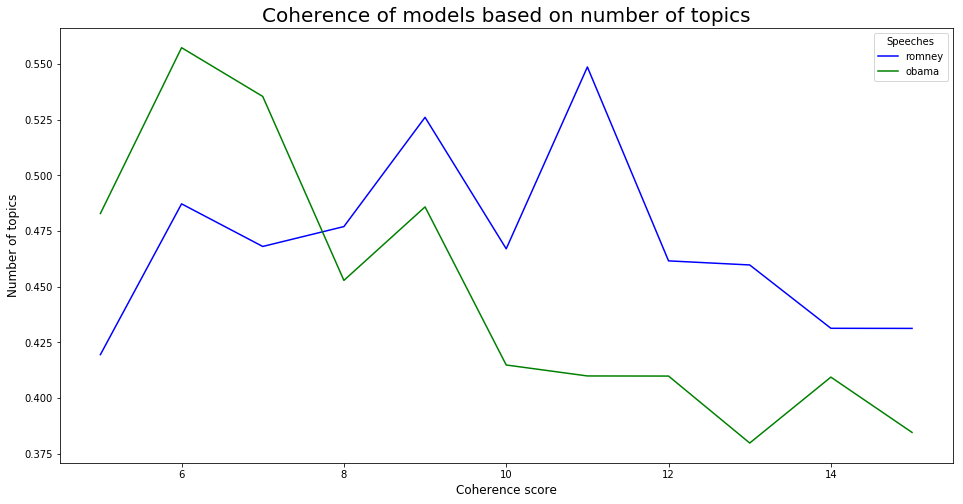

In [125]:
plt.figure(figsize=(16,8))
col = dict()
col['obama'] = 'green'; col['romney'] = 'blue'
for fld in corpus_tfidf.keys() :
    plt.plot(x[fld],y[fld], color=col[fld], label=fld)
plt.legend(title='Speeches')
plt.title("Coherence of models based on number of topics", fontsize=20)
plt.xlabel("Coherence score",fontsize=12)
plt.ylabel("Number of topics",fontsize=12)
plt.show()

In [127]:
lda = dict(); num_topics = dict()
num_topics['obama'] = 6;  num_topics['romney'] = 11
num_words = 15

for fld in corpus_tfidf.keys() :
    lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                              chunksize=100, random_state=123, update_every=1)


In [129]:
# Display the topics and words associated
for fld in corpus_tfidf.keys() :  
    print('*'*80)
    print(fld.upper())
    print(pd.DataFrame({"Topic "+ str(i+101)[1:]:[topic[0] for topic in lda[fld].show_topic(i,num_words)] \
                                    for i in range(num_topics[fld])}, index = [i+1 for i in range(num_words)] ))

********************************************************************************
ROMNEY
       Topic 01   Topic 02      Topic 03      Topic 04 Topic 05     Topic 06  \
1      applause      found       library    manchester  liberal         ship   
2      remember  searching        valley      vigilant    going     properly   
3        beacon      reply      provided     incubator  program       wright   
4       bidding  requested  presidential        athens   school       edison   
5     blueprint    perhaps        reject          bank   crisis         hero   
6       violate     cancel         marry          memo   budget      veteran   
7     misguided      leave     christian       upright   nation    professor   
8        detour    nothing         jerry        truman   little       thomas   
9        insist   aluminum      activist        winter   people  businessman   
10  challenging    illegal        prince        weight  teacher        glass   
11       ticket      could      

In [130]:
# Visualize - LDA using pyLDAvis
vis = dict()
for fld in corpus_tfidf.keys() :
    vis[fld] = pyLDAvis.gensim.prepare(lda[fld],corpus=corpus_tfidf[fld],dictionary=corpus_dict, mds = 'mmds')

C:\Users\acer\Anaconda3\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [131]:
# Print topics in Romney's speeches
print(list(corpus_tfidf.keys())[0])
vis[list(corpus_tfidf.keys())[0]]

romney


PreparedData(topic_coordinates=            Freq  cluster  topics             x         y
topic                                                    
4      56.791042        1       1  4.526963e-02 -0.030908
8       6.112673        1       2 -9.287901e-07  0.002026
9       6.034297        1       3 -1.210128e-03  0.005688
0       5.240801        1       4 -1.726784e-03  0.008565
1       4.567382        1       5 -5.138175e-03 -0.004319
10      4.338066        1       6 -9.071250e-03  0.001416
7       4.146058        1       7 -6.790279e-03  0.001368
2       3.878405        1       8 -7.203794e-03  0.005135
3       3.322262        1       9 -5.305983e-03  0.005285
6       2.789970        1      10 -4.379534e-03  0.003733
5       2.779041        1      11 -4.442779e-03  0.002009, topic_info=     Category      Freq            Term     Total  loglift  logprob
term                                                               
4660  Default  0.000000           found  0.000000  30.0000  30.0000
6985  Default  0.000000           reply  0.000000  29.0000  29.0000
482   Default  0.000000       searching  0.000000  28.0000  28.0000
4190  Default  0.000000       requested  0.000000  27.0000  27.0000
6932  Default  0.000000         perhaps  0.000000  26.0000  26.0000
85    Default  0.000000          cancel  0.000000  25.0000  25.0000
663   Default  0.000000         comment  0.000000  24.0000  24.0000
6042  Default  0.000000        applause  0.000000  23.0000  23.0000
9028  Default  0.000000          closed  0.000000  22.0000  22.0000
3141  Default  0.000000         nothing  0.000000  21.0000  21.0000
1256  Default  0.000000           leave  0.000000  20.0000  20.0000
739   Default  0.000000        remember  0.000000  19.0000  19.0000
5217  Default  0.000000           berta  0.000000  18.0000  18.0000
2593  Default  0.000000          falcon  0.000000  17.0000  17.0000
8859  Default  0.000000         library  0.000000  16.0000  16.0000
6116  Default  0.000000    presidential  0.000000  15.0000  15.0000
2966  Default  0.000000       inherited  0.000000  14.0000  14.0000
2881  Default  0.000000          regime  0.000000  13.0000  13.0000
996   Default  0.000000           kerry  0.000000  12.0000  12.0000
8571  Default  0.000000          valley  0.000000  11.0000  11.0000
8272  Default  0.000000         veteran  0.000000  10.0000  10.0000
332   Default  0.000000        provided  0.000000   9.0000   9.0000
3005  Default  0.000000        audience  0.000000   8.0000   8.0000
5965  Default  0.000000            ship  0.000000   7.0000   7.0000
1966  Default  0.000000           marry  0.000000   6.0000   6.0000
2260  Default  0.000000          genius  0.000000   5.0000   5.0000
8659  Default  0.000000          ronald  0.000000   4.0000   4.0000
8019  Default  0.000000           david  0.000000   3.0000   3.0000
8562  Default  0.000000           legal  0.000000   2.0000   2.0000
5762  Default  0.000000           could  0.000000   1.0000   1.0000
...       ...       ...             ...       ...      ...      ...
941   Topic11  0.007337       professor  0.094146   1.0312  -8.2187
8079  Topic11  0.007261          thomas  0.093913   1.0232  -8.2292
2932  Topic11  0.006086            drop  0.079226   1.0168  -8.4056
3086  Topic11  0.006086      contractor  0.079226   1.0168  -8.4056
9418  Topic11  0.006086           sunny  0.079226   1.0168  -8.4056
7506  Topic11  0.006086        breathed  0.079226   1.0168  -8.4056
7388  Topic11  0.006086          adrift  0.079226   1.0168  -8.4056
5363  Topic11  0.006077        visiting  0.079177   1.0158  -8.4072
2908  Topic11  0.006077         wounded  0.079177   1.0158  -8.4072
1015  Topic11  0.006077      purchasing  0.079177   1.0158  -8.4072
2769  Topic11  0.006195      incredible  0.084330   0.9720  -8.3880
2620  Topic11  0.006194      difficulty  0.084830   0.9660  -8.3881
8284  Topic11  0.006366     strengthens  0.088513   0.9509  -8.3606
1205  Topic11  0.006664         airport  0.093008   0.9471  -8.3149
1969  T

In [132]:
# Print topics in Obama's speeches
print(list(corpus_tfidf.keys())[1])
vis[list(corpus_tfidf.keys())[1]]

obama


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      89.866806        1       1  0.006178  0.047428
5       4.426677        1       2 -0.023652 -0.041634
4       1.857754        1       3  0.003871 -0.001310
2       1.379222        1       4  0.004569 -0.001522
0       1.378225        1       5  0.004682 -0.001528
3       1.091314        1       6  0.004352 -0.001433, topic_info=     Category      Freq          Term     Total  loglift  logprob
term                                                             
5816  Default  0.000000       opposed  0.000000  30.0000  30.0000
8533  Default  0.000000        secure  0.000000  29.0000  29.0000
7535  Default  0.000000     sacrifice  0.000000  28.0000  28.0000
4683  Default  0.000000          tear  0.000000  27.0000  27.0000
2473  Default  0.000000     ignorance  0.000000  26.0000  26.0000
9712  Default  0.000000       without  0.000000  25.0000  25.0000
1063  Default  0.000000         pearl  0.000000  24.0000  24.0000
6336  Default  0.000000        patton  0.000000  23.0000  23.0000
5176  Default  0.000000      devotion  0.000000  22.0000  22.0000
7087  Default  1.000000   grandfather  1.000000  21.0000  21.0000
1723  Default  0.000000        middle  0.000000  20.0000  20.0000
2034  Default  0.000000        harbor  0.000000  19.0000  19.0000
4636  Default  0.000000     supported  0.000000  18.0000  18.0000
8489  Default  0.000000        income  0.000000  17.0000  17.0000
3645  Default  0.000000         clear  0.000000  16.0000  16.0000
3966  Default  0.000000         enemy  0.000000  15.0000  15.0000
1286  Default  0.000000  undetermined  0.000000  14.0000  14.0000
5398  Default  0.000000         youth  0.000000  13.0000  13.0000
7915  Default  0.000000     willingly  0.000000  12.0000  12.0000
8303  Default  0.000000   intolerance  0.000000  11.0000  11.0000
931   Default  0.000000      neighbor  0.000000  10.0000  10.0000
4853  Default  0.000000       passion  0.000000   9.0000   9.0000
4564  Default  0.000000        oppose  0.000000   8.0000   8.0000
9237  Default  0.000000       despair  0.000000   7.0000   7.0000
7841  Default  0.000000        signed  0.000000   6.0000   6.0000
8390  Default  0.000000    depression  0.000000   5.0000   5.0000
5321  Default  0.000000        larger  0.000000   4.0000   4.0000
4707  Default  0.000000         drive  0.000000   3.0000   3.0000
1103  Default  0.000000         based  0.000000   2.0000   2.0000
9022  Default  0.000000         after  0.000000   1.0000   1.0000
...       ...       ...           ...       ...      ...      ...
8171   Topic6  0.001739      domenech  0.103428   0.4324  -9.1185
3280   Topic6  0.001739     bucharest  0.103428   0.4324  -9.1185
9649   Topic6  0.001739    compounded  0.103428   0.4324  -9.1185
1724   Topic6  0.001739        greece  0.103428   0.4324  -9.1185
7378   Topic6  0.001739      mongolia  0.103428   0.4324  -9.1185
9117   Topic6  0.001739       mutates  0.103428   0.4324  -9.1185
3133   Topic6  0.001739    publishing  0.103428   0.4324  -9.1185
4653   Topic6  0.001739   unknowingly  0.103428   0.4324  -9.1185
7336   Topic6  0.001739       tamiflu  0.103428   0.4324  -9.1185
268    Topic6  0.001739        athens  0.103428   0.4324  -9.1185
7546   Topic6  0.001739   predictably  0.103428   0.4324  -9.1185
1401   Topic6  0.001739       shortly  0.103428   0.4324  -9.1185
3112   Topic6  0.001739       romania  0.103428   0.4324  -9.1185
4699   Topic6  0.001739        turkey  0.103428   0.4324  -9.1185
66     Topic6  0.001918        animal  0.116934   0.4076  -9.0206
7801   Topic6  0.002168     southeast  0.146504   0.3047  -8.8980
7656   Topic6  0.001836     surprised  0.112824   0.3993  -9.0646
4833   Topic6  0.001801       mutated  0.110526   0.4010  -9.0835
8230   Topic6  0.001801       bangkok  0.110526   0.4010  -9.0835
9371   Topic6  0.001801     antiviral  0.110526   0.4010  -9.0835
3074   Topic6  0.001801    